In [22]:
''' Imports, constants and utils '''

%matplotlib inline
import matplotlib.pyplot as plt

import os
import os.path

import cv2 as cv
import numpy as np
from skimage import feature
from peeptree.processing import ImageProcessor
from peeptree.model import ImageFeatureExtractor, TreeClassifierSVM

# defining segment dimensions
block_size = 20
n_blocks_row = 240 // 20
n_blocks_col = 320 // 20

# defining necessary paths
image_extensions = ["jpg", "png"]
trained_clf_path = "/home/one_wizard_boi/Documents/Projects/DJI-tree-detection/peeptree/classifier.pickle"
image_dir = "/home/one_wizard_boi/Documents/Projects/DJI-tree-detection/TrainingData/OriginalImages"

# defining a target image
target_image_path = "images/20200126_151625.jpg"

# defining lbp parameters
lbp_radius = 2
lbp_n_points = 10

# defining requirements for image segmentation
class DetectedObject():

    ''' Coordinate representation of objects in an image '''

    def __init__(self, top_left, bottom_right):
        
        '''
        Parameters
        ----------
        top_left (int, int) : top left bounding box coordinates (row, col)
        bottom_right (int, int) : bottom right bounding box coordinates (row, col)
        '''

        self.top_left = top_left
        self.bottom_right = bottom_right

        
def overlay_segment_rois(image, segments):

    ''' Overlay detected segments ROIs on source image '''

    for row_i in range(n_blocks_row):
        for col_i in range(n_blocks_col):
            if segments[row_i][col_i] is not None:
                image = cv.rectangle(image, segments[row_i][col_i].top_left, 
                                     segments[row_i][col_i].bottom_right, (0, 0, 255), 1)                                

    return image


def compute_channel_histogram(lbp):
    
    ''' Computes LBP histogram '''    
    
    plt.hist(lbp.ravel(), bins = range(0, lbp.max()+2)) 
    plt.show()

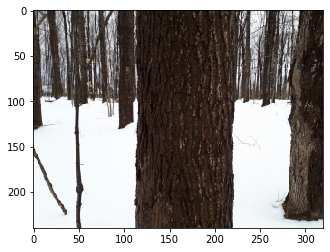

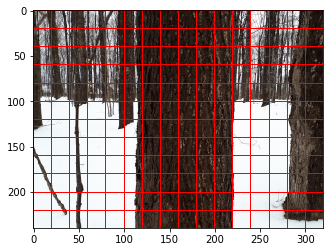

In [23]:
''' Visualising image segmentation '''

# loading, resizing and displaying he target image
image = cv.imread(target_image_path, cv.IMREAD_COLOR)
image = cv.resize(image, (320, 240), interpolation = cv.INTER_AREA)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.show()

# defining container for segments
object_segments = [[None] * n_blocks_col for i in range(n_blocks_row)]

# going through the blocks of the input image
for row_i in range(n_blocks_row):
    seg_row_start = row_i * block_size
    for col_i in range(n_blocks_col):
        
        # collecting object segments
        seg_col_start = col_i * block_size
        seg_top_left = (seg_col_start, seg_row_start)
        seg_bottom_right = (seg_col_start + block_size, seg_row_start + block_size)
        object_segments[row_i][col_i] = DetectedObject(seg_top_left, seg_bottom_right)
        
image = overlay_segment_rois(image, object_segments)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.show()

In [28]:
raw_color_hist = [40, 60, 10, 80, 10, 10, 10, 10, 10, 15, 35, 5, 80, 10, 15]
print("avant normalisation          : ", raw_color_hist)
print("apres normalisation (/somme) : ", [element/sum(raw_color_hist) for element in raw_color_hist])

avant normalisation          :  [40, 60, 10, 80, 10, 10, 10, 10, 10, 15, 35, 5, 80, 10, 15]
apres normalisation (/somme) :  [0.1, 0.15, 0.025, 0.2, 0.025, 0.025, 0.025, 0.025, 0.025, 0.0375, 0.0875, 0.0125, 0.2, 0.025, 0.0375]


In [26]:
stats = [128.4, 82.627]
print("avant normalisation        : ", stats)
print("apres normalisation (/255) : ", [element/255 for element in stats])

avant normalisation        :  [128.4, 82.627]
apres normalisation (/255) :  [0.5035294117647059, 0.32402745098039215]


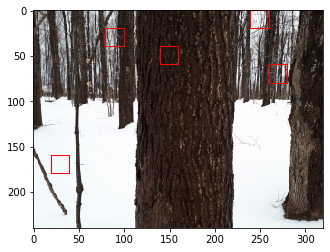

Processing segment no. 1


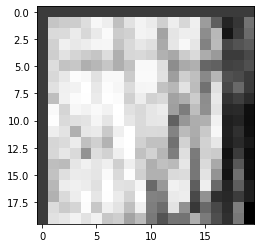

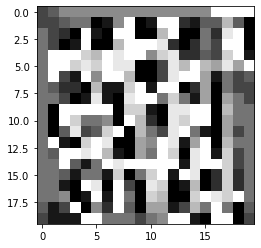

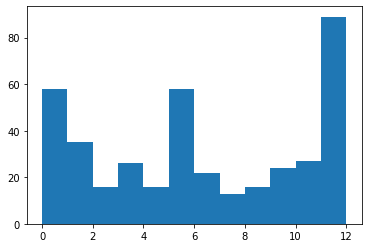

Processing segment no. 2


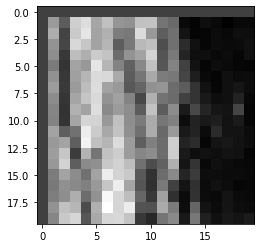

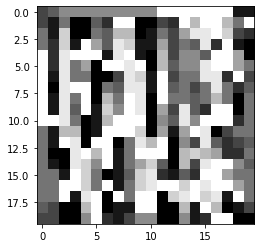

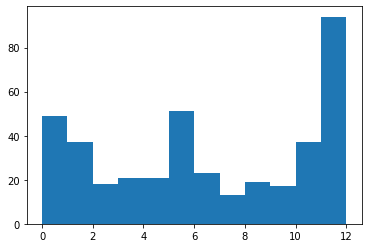

Processing segment no. 3


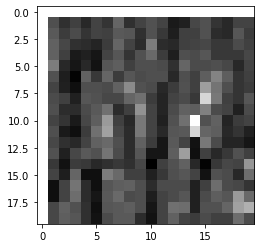

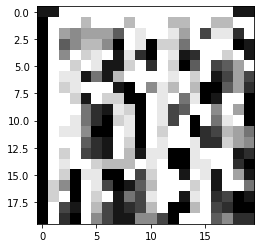

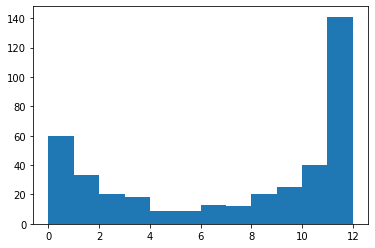

Processing segment no. 4


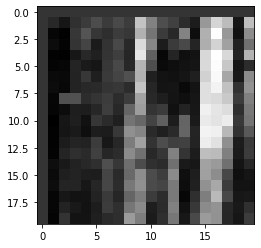

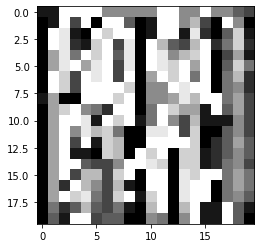

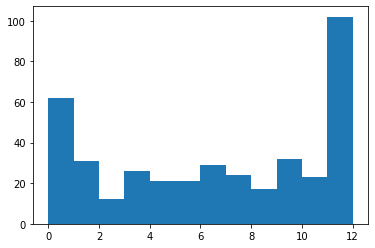

Processing segment no. 5


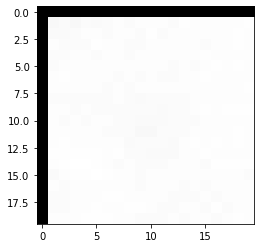

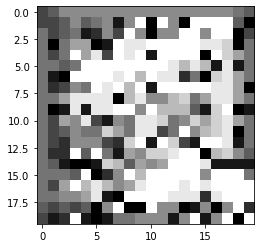

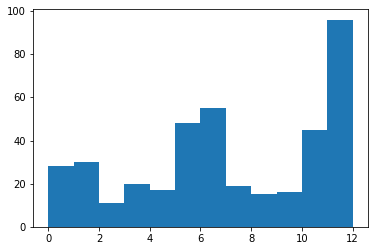

In [24]:
''' Visualizing LB}P '''

# loading and resizing the target image
image = cv.imread(target_image_path, cv.IMREAD_COLOR)
image = cv.resize(image, (320, 240), interpolation = cv.INTER_AREA)

# defining container for segments
target_segments = [(0, 12), (1, 4), (2, 7), (3, 13), (8, 1)]
collected_segments = []
object_segments = [[None] * n_blocks_col for i in range(n_blocks_row)]

# going through the blocks of the input image
for row_i in range(n_blocks_row):
    seg_row_start = row_i * block_size
    for col_i in range(n_blocks_col):

        # checking if segment is in target segments
        check = False
        for target_seg in target_segments : 
            if (row_i == target_seg[0]) and (col_i == target_seg[1]):
                check = True
                break
        
        # collecting and displaying target segments 
        if check:
        
            # extracting current subimage
            seg_col_start = col_i * block_size
            image_seg = image[seg_row_start : seg_row_start + block_size, seg_col_start : seg_col_start + block_size]
            collected_segments.append(image_seg)

            # collecting object segments
            seg_top_left = (seg_col_start, seg_row_start)
            seg_bottom_right = (seg_col_start + block_size, seg_row_start + block_size)
            object_segments[row_i][col_i] = DetectedObject(seg_top_left, seg_bottom_right)
    
# displaying the image with target overlays
image = overlay_segment_rois(image, object_segments)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.show()

# displaying the collecting segments
for seg_i, seg in enumerate(collected_segments):

    print("Processing segment no.", seg_i + 1)
    
    # displaying the raw segment
    seg = cv.cvtColor(seg, cv.COLOR_BGR2GRAY)
    plt.imshow(seg, cmap='gray')
    plt.show()
   
    # displaying the lbp image and hist for the segment
    lbp = feature.local_binary_pattern(seg, lbp_n_points, lbp_radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, lbp_n_points + 3), 
                               range=(0, lbp_n_points + 2))
    
    # displaying the image version
    plt.imshow(lbp, cmap='gray')
    plt.show()
    
    # displaying the histogram version
    compute_channel_histogram(lbp.astype("int"))
    